In [1]:
#!/usr/bin/python
#coding=utf-8
import xlrd

def read_xls_file():                            #读取excel文件
    data = xlrd.open_workbook('./ex3data.xls')  #打开文件
    sheet1 = data.sheet_by_index(0)             #获取sheet
    m = sheet1.nrows                            #获取行大小
    n = sheet1.ncols                            #获取列大小
    dataMat = []                         
    label = []                                  #标签
    for i in range(m):                          #枚举每一行
        row_data = sheet1.row_values(i)         #获取一行数据
        del(row_data[0])                        #删除第一列
        if(i == 0):                             #标签
           label = row_data                     #获取标签 
        elif(i > 0 ):                           #其他数据      
           dataMat.append(row_data)
    return dataMat,label

In [2]:
#!/usr/bin/python
#coding=utf-8
from numpy import *
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.animation as ai
import numpy as np
import math

def splitData(data, axis, value):               #数据分割
    retdata = []                                #包含value的数据
    splitdata = []                              #不包含value的数据
    for fat in data:
        reducefat = fat[:axis]
        reducefat.extend(fat[axis + 1:])
        if fat[axis] == value:
           retdata.append(reducefat)
        else:
           splitdata.append(reducefat)
    return retdata
           

def shannon_data(data):                       #经验熵
    number = len(data)
    labelcount = {}
    for d in data:
        label = d[-1]
        if label not in labelcount.keys():
          labelcount[label] = 0
        labelcount[label] += 1
    shannon = 0.0
    for key in labelcount:
        p = float(labelcount[key]) / number
        shannon -= p * math.log(p, 2)          #H(pi) = p * log(p, 2)
    return shannon

def shannon_conditional(data, i, feat, unique):  #条件熵
    ce =0.0
    for value in unique:
        subdata = splitData(data, i , value)
        p = len(subdata) / float(len(data))
        ce +=p * shannon_data(subdata)
    return ce

def Infor_Gain(data, base, i):          #计算信息增益
    featList = [example[i] for example in data]  # 第i维特征列表
    uniqueVals = set(featList)                   # 转换成集合
    newEntropy = shannon_conditional(data, i, featList, uniqueVals)
    infoGain = base - newEntropy                 # 信息增益，就是熵的减少，也就是不确定性的减少
    return infoGain


def id3(data):
    numFeatures = len(data[0]) - 1  # 最后一列是分类
    base = shannon_data(data)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):  # 遍历所有维度特征
        infoGain = Infor_Gain(data, base, i)
        if (infoGain > bestInfoGain):  # 选择最大的信息增益
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature  # 返回最佳特征对应的维度



In [3]:
#!/usr/bin/python
# coding=utf-8
import matplotlib.pyplot as plt
import sys
import importlib
import operator

# 定义文本框和箭头格式
#reload(sys)
importlib.reload(sys)
#sys.setdefaultencoding('utf-8')
matplotlib.rcParams['font.sans-serif']=['Droid Sans Fallback']
#myfont = matplotlib.font_manager.FontProperties(fname="simsun.ttc")
decisionNode = dict(boxstyle="sawtooth", color='#ffffff')  #定义判断结点形态
leafNode = dict(boxstyle="round4", color='#7FFF00')  #定义叶结点形态
arrow_args = dict(arrowstyle="<-", color='#008b00')  #定义箭头
 
#绘制带箭头的注释
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)
 
 
#计算叶结点数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs
 
 
#计算树的层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth
 
 
#在父子结点间填充文本信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center")
 
 
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)  #在父子结点间填充文本信息
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  #绘制带箭头的注释
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, key)
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, key)
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD
 
 
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW;
    plotTree.yOff = 1.0;
    plotTree(inTree, (0.5, 1.0), '')
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    plt.show()

def majority(classList):
    classCount = {}  # 这是一个字典
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]


def createTree(data, labels):
    classlist = [example[-1] for example in data]
    if classlist.count(classlist[0]) == len(classlist):
       return classlist[0]
    if len(data[0]) == 1:
       return majority(classlist)
    bestfeat = id3(data)
    bestfeatlabel = labels[bestfeat]
    mytree = {bestfeatlabel:{}}
    del(labels[bestfeat])
    featvalues = [example[bestfeat] for example in data]
    unique = set(featvalues)
    for value in unique:
        sublabel = labels[:]
        mytree[bestfeatlabel][value] = createTree(splitData(data,bestfeat, value),sublabel)
    return mytree


运行时间: 0.0005898999999942589 Seconds
正确率 0.7647058823529411


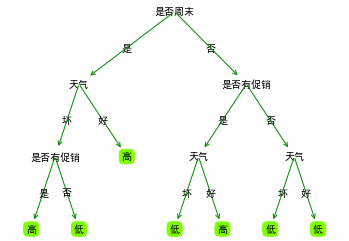

In [4]:
#!/usr/bin/python
#coding=utf-8

from pylab import *
from time import perf_counter
import matplotlib.pyplot as plt


def classify(inputTree,featLabels,testVec):  #根据已有的决策树，对给出的数据进行分类
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)  #这里是将标签字符串转换成索引数字
    for key in secondDict.keys():
        if testVec[featIndex] == key:       #如果key值等于给定的标签时
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key],featLabels,testVec) #递归调用分类
                #print classLabel
            else: classLabel = secondDict[key] #此数据的分类结果

    return classLabel

def storeTree(inputTree, filename): #储存决策树
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()

def grabTree(filename): #读取决策树
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)


def pred(data,myTree,labelcopy): #预测函数
    m, n =shape(data)
    sum1 = 0
    for i in range(m):
        s = classify(myTree,labelcopy,data[i])
        if (s == data[i][3]):
           sum1 +=1
    print ("正确率" , float(sum1)/float(m))

data, labels = read_xls_file()
labelcopy = []
m = len(labels)
for i in range(m):
    labelcopy.append(labels[i])


start = perf_counter()
myTree = createTree(data, labels)
end = perf_counter()
print('运行时间: %s Seconds'%(end-start))
pred(data,myTree,labelcopy)
createPlot(myTree)